# Lab for answering question C
Responsible: Moritz
Question: Are there trends visible that could be due to climate change?

In [44]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache

In [45]:
transformed_df_serial_path = "../data/data_transformed.pickle"

with open(transformed_df_serial_path, "rb") as file:
    df: pd.DataFrame = pickle.load(file)

assert isinstance(df, pd.DataFrame),f"The serialized object in {transformed_df_serial_path} is not a pandas dataframe!"
assert len(df)!=0, "The serialized dataframe contains no data!"


disaster_classification: pd.DataFrame = pd.read_csv("../data/disaster_classification.csv")
disaster_subgroups = set(disaster_classification.loc[disaster_classification["Disaster Sub-Group"].notna(), "Disaster Sub-Group"])

Dumping all data before 1950 as it is not relevant to climate change.

In [46]:
cutoff_date = 1950 # TODO check
df = df[df["Start_Year"] > cutoff_date]
min_year = df["Start_Year"].min()
max_year = df["Start_Year"].max()
df

,Disaster_Group,Disaster_Subgroup,Disaster_Type,Disaster_Subtype,Disaster_Subsubtype,Country,ISO,Region,Continent,Associated_Dis,Associated_Dis2,Start_Year,End_Year,Total_Deaths,Total_Affected
203,Natural,Meteorological,Storm,<NA>,<NA>,Bangladesh,BGD,Southern Asia,Asia,<NA>,<NA>,1951,1951,200,<NA>
204,Natural,Hydrological,Landslide,Avalanche,<NA>,Switzerland,CHE,Western Europe,Europe,<NA>,<NA>,1951,1951,92,<NA>
205,Natural,Hydrological,Flood,<NA>,<NA>,China,CHN,Eastern Asia,Asia,<NA>,<NA>,1951,1951,4800,<NA>
206,Natural,Meteorological,Storm,Convective storm,Tornado,Comoros (the),COM,Eastern Africa,Africa,<NA>,<NA>,1951,1951,500,<NA>
207,Natural,Geophysical,Volcanic activity,Ash fall,<NA>,Indonesia,IDN,South-Eastern Asia,Asia,<NA>,<NA>,1951,1951,1300,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16483,Natural,Biological,Epidemic,Viral disease,<NA>,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,<NA>,<NA>,2022,2022,8,607
16484,Natural,Biological,Epidemic,Viral disease,<NA>,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,<NA>,<NA>,2022,2022,5,141
16485,Natural,Biological,Epidemic,Viral disease,<NA>,Zimbabwe,ZWE,Eastern Africa,Africa,<NA>,<NA>,2022,2022,750,6551
16486,Natural,Biological,Epidemic,Viral disease,<NA>,Timor-Leste,TLS,South-Eastern Asia,Asia,<NA>,<NA>,2022,2022,20,1353


## Get Yearly Deaths

Read the documentation in utility_functions.py for info on parameters etc.

In [47]:
%run -i utility_functions.py # importing the function from utility_functions.py

In [48]:
get_yearly_deaths(df, include_zero=True).to_frame() # Deaths grouped by year. Rows with zero deaths can be excluded

,Total_Deaths
Year,
1951,18227.0
1952,6886.0
1953,12997.0
1954,41847.0
1955,5556.0
...,...
2018,13832.5
2019,23838.166667
2020,15690.166667


In [60]:
get_yearly_deaths(df, custom_index=["Country", "Disaster_Subtype"], include_zero=False).to_frame() # Deaths can be grouped by year and each of custom_index

Total_Deaths
Year Country                            Disaster_Subtype              
1951 Comoros (the)                      Convective storm         500.0
     El Salvador                        Ground movement         1100.0
     Indonesia                          Ash fall                1300.0
     Jamaica                            Tropical cyclone         154.0
     Japan                              Tropical cyclone         943.0
...                                                                ...
2022 Venezuela (Bolivarian Republic of) Landslide                109.0
     Viet Nam                           Convective storm          11.0
                                        Tropical cyclone          19.0
     Yemen                              Flash flood               13.0
     Zimbabwe                           Viral disease            750.0

[6565 rows x 1 columns]

## Regarding Groupby and Pandas Datatypes

Pandas usually uses numpy datatypes. However, **numpy integer arrays do not allow for null values (np.nan)**. That's why pandas introduces their own Integer array, which can inlcude null values (pd.NA). However, for groupby operations these pd.NA values can cause problems, so it is advisable to convert back to a numpy float array (which does allow for np.nan) before applying the groupby.

In [50]:
series = pd.Series(np.arange(10)) # just for demonstration

series.astype("int32") # <-- "int32" (small i) = numpy int, no empty values
series.astype("Int32") # <-- "Int32" (big i) = pandas int, allows empty values (pd.NA)
series.astype("float32") # <-- numpy float, allows empty values (np.nan)
pass

In [51]:
groupby_base = df.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32})

groupby_base[["Disaster_Subgroup", "Total_Deaths"]].groupby(["Disaster_Subgroup"]).mean()

,Total_Deaths
Disaster_Subgroup,
Biological,215.732171
Climatological,8430.825095
Extra-terrestrial,NaN
Geophysical,1351.783962
Hydrological,507.803319
Meteorological,312.845705


## Data Exploration

In [52]:
year_range = range(min_year, max_year)

def fill_missing_year():
    set(groupby_base.groupby("Start_Year").size().rename("No_Disasters").index).difference(year_range)
    # TODO

@lru_cache(2)
def get_yearly_disaster_count(secondary_index:str=None, include_zero:bool=True) -> pd.Series:
    """Calculates number of disaster occurrences grouped by the secondary_index column for each Start_Year.

    Parameters
    ----------
    secondary_index: str
        Must be a column label of groupby_base.
        Probably one of [Disaster_Subgroup, Disaster_Type, Disaster_Subtype, Disaster_Subsubtype]
        If None than result will not be grouped.
    include_zero: bool
        If True zero counts will be included, otherwise the rows are dropped
    Returns
    -------
    pd.Series named "No_Disasters"
    """


    index = ["Start_Year", secondary_index] if secondary_index is not None else ["Start_Year"]
    if not include_zero:
        return groupby_base.groupby(index).size().rename("No_Disasters")

    count_nonzero = get_yearly_disaster_count(secondary_index, include_zero=False)
    if secondary_index is not None:
        return count_nonzero.unstack(fill_value=0).stack().rename("No_Disasters")
    return count_nonzero

def get_yearly_pct_change_to_initial(secondary_index: str):
    """Calculates yearly percentage change number of disaster occurrences compared to the first year, grouped by the respective column.

    Parameters
    ----------
    secondary_index: str
        Must be a column label of groupby_base.
        Probably one of [Disaster_Subgroup, Disaster_Type, Disaster_Subtype, Disaster_Subsubtype]

    Returns
    -------
    pd.Series with Multiindex ("Start_Year", secondary_index) and named "Percent_Change"
    """
    count_nonzero = get_yearly_disaster_count(secondary_index, include_zero=False)
    return count_nonzero.groupby(level=[1], group_keys=False).apply(lambda x: (x.div(x.iloc[0]) -1) *100).fillna(0).rename("Percent_Change")


Text(0.5, 0, 'Year AC.')

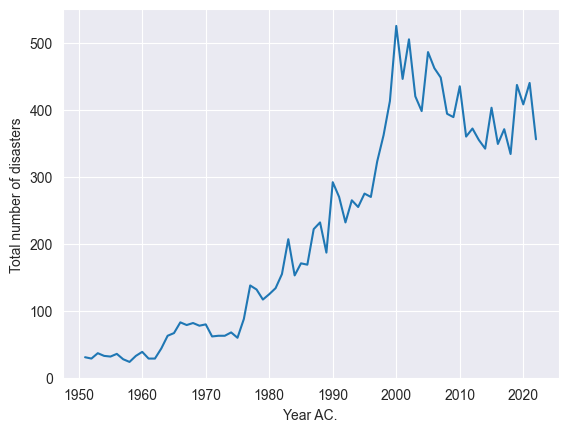

In [53]:
total_disaster_per_year = get_yearly_disaster_count(include_zero=True)
plt.plot(total_disaster_per_year.index, total_disaster_per_year)
plt.ylabel("Total number of disasters")
plt.xlabel("Year AC.")

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

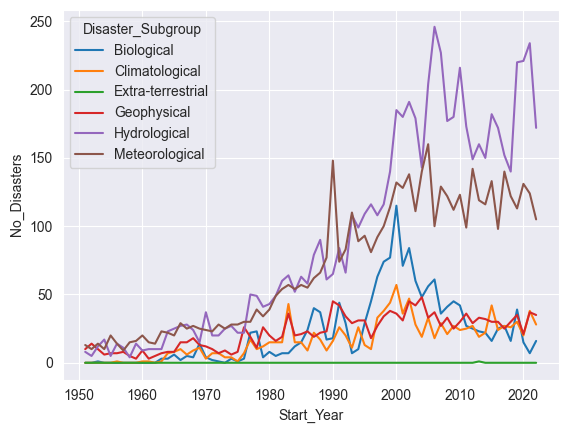

In [54]:
sns.lineplot(data=get_yearly_disaster_count("Disaster_Subgroup").reset_index(), x="Start_Year",y="No_Disasters", hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='Percent_Change'>

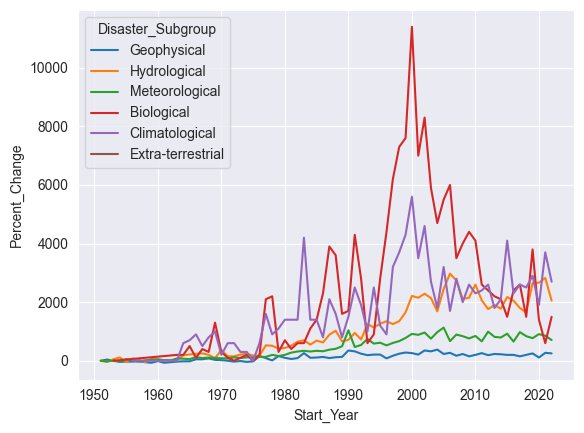

In [55]:
# disaster_subgroup = disaster_classification["Disaster Sub-Group"]
sns.lineplot(data=get_yearly_pct_change_to_initial("Disaster_Subgroup").reset_index(),
             x="Start_Year",
             y="Percent_Change",
             hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

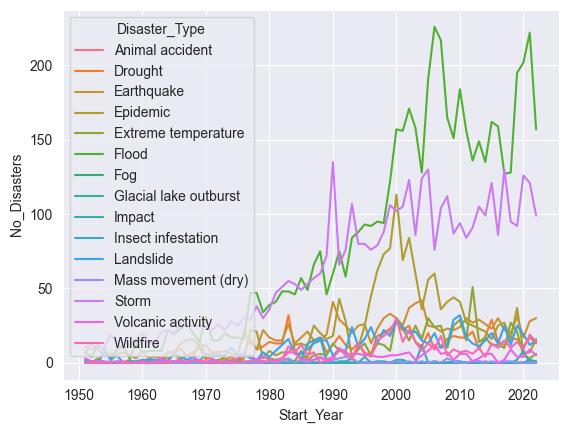

In [56]:
sns.lineplot(data=get_yearly_disaster_count("Disaster_Type").reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Type")

In [57]:
get_yearly_disaster_count(secondary_index="Disaster_Subtype", include_zero=False)

Start_Year  Disaster_Subtype        
1951        Ash fall                     3
            Avalanche                    1
            Cold wave                    1
            Convective storm             1
            Ground movement              7
                                        ..
2022        Pyroclastic flow             1
            Riverine flood               1
            Severe winter conditions     1
            Tropical cyclone            49
            Viral disease                8
Name: No_Disasters, Length: 1031, dtype: int64

Backup

In [58]:
first_year_index = tuple(no_disasters_per_type_and_year[min_year].index)

missing_from_first = disaster_subgroups.difference(first_year_index)
no_disasters_per_type_and_year.add(
    pd.Series(
        data=np.zeros(len(missing_from_first)),
        index=pd.MultiIndex.from_tuples([(min_year, subgroup) for subgroup in missing_from_first])))


NameError: name 'no_disasters_per_type_and_year' is not defined